In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import glob
import os

In [293]:
path = 'home/my_lolbo_cleaner/lolbo_scripts/done'

In [2]:
def combine_files(base,output_file):
    files = sorted(glob.glob(os.path.join(base,"*.npz")))
    if not files:
        print(f"no npz files found in {base}")
        return
    
    merged = {}
    
    for npz in files:
        current_data = np.load(npz)
        for key in current_data:
            if key in merged:
                merged[key] = np.concatenate((merged[key],current_data[key]),axis=0)
            else:
                merged[key] = current_data[key]
    
    np.savez(output_file,**merged)

In [3]:
lst = os.listdir(path)

NameError: name 'path' is not defined

In [ ]:
for run in lst:
    if run.startswith('.'):
        continue
    base = os.path.join(path,run)
    #combine the files
    combine_files(base,f"run-{run}")

In [3]:
file = "run-vital-galaxy-65.npz"


In [4]:
data = np.load(file)

In [5]:
print(data.files)

['z_next', 'y_next', 'mean', 'variance', 'length']


In [6]:
for key in data:
    array = data[key]
    print(f"Statistics for '{key}':")
    print(f"  Shape: {array.shape}")
    print(f"  Data Type: {array.dtype}")
    print(f"  Mean: {np.mean(array)}")
    print(f"  Standard Deviation: {np.std(array)}")
    print(f"  Min: {np.min(array)}")
    print(f"  Max: {np.max(array)}")
    print(f"  Number of Non-zero Elements: {np.count_nonzero(array)}")
    print("-" * 40)

Statistics for 'z_next':
  Shape: (70, 10, 256)
  Data Type: float32
  Mean: nan
  Standard Deviation: nan
  Min: nan
  Max: nan
  Number of Non-zero Elements: 179200
----------------------------------------
Statistics for 'y_next':
  Shape: (70, 10)
  Data Type: float64
  Mean: nan
  Standard Deviation: nan
  Min: nan
  Max: nan
  Number of Non-zero Elements: 648
----------------------------------------
Statistics for 'mean':
  Shape: (70, 10, 1)
  Data Type: float32
  Mean: 0.08337937295436859
  Standard Deviation: 0.030294375494122505
  Min: 0.005136539228260517
  Max: 0.14844276010990143
  Number of Non-zero Elements: 700
----------------------------------------
Statistics for 'variance':
  Shape: (70, 10, 1)
  Data Type: float32
  Mean: 0.29693156480789185
  Standard Deviation: 0.17612344026565552
  Min: 0.12193779647350311
  Max: 1.0702733993530273
  Number of Non-zero Elements: 700
----------------------------------------
Statistics for 'length':
  Shape: (70, 10)
  Data Type: f

In [7]:
y_next = data['y_next']
z_next = data['z_next']
mean = data['mean']
variance = data['variance']
length = data['length']

In [8]:
shaped_y_next = np.reshape(y_next,-1)
shaped_z_next = np.reshape(z_next,(-1,256))
shaped_mean = np.reshape(mean,(-1,1))
shaped_variance = np.reshape(variance,(-1,1))
shaped_length = np.reshape(length,-1)


In [9]:
z_mask = ~np.isnan(shaped_z_next).all(axis=1)

filtered_z = shaped_z_next[z_mask]
filtered_y = shaped_y_next[z_mask]
filtered_mean = shaped_mean[z_mask]
filtered_variance = shaped_variance[z_mask]
filtered_length = shaped_length[z_mask]

In [10]:

def cv_plot(q_middle, q_lower, q_upper, Y_true, ax=None,title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    q_middle = q_middle.squeeze()
    q_lower = q_lower.squeeze()
    q_upper = q_upper.squeeze()
    Y_true = Y_true.squeeze()
    
    min_val = np.minimum(Y_true.min(),q_lower.min())
    max_val = np.maximum(Y_true.max(),q_lower.max())
    print(min_val)
    print(max_val)
    
    min_val, max_val = min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val)
    ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
    print(min_val)
    print(max_val)
    yerr1, yerr2 = q_middle - q_lower, q_upper - q_middle
    
    yerr = np.vstack([yerr2,yerr1])
    
    # creating our colors
    n = len(Y_true)
    indices = np.linspace(0,1,n)
    cmap = mp.colormaps['winter']
    
    markers, caps, bars = ax.errorbar(
        q_middle,
        Y_true,
        yerr=yerr,
        fmt=".",
        alpha=0.6,
        elinewidth=2.0,
        ms=14,
        ecolor="gray",
    )
    [bar.set_alpha(0.8) for bar in bars]
    [cap.set_alpha(1) for cap in caps]
    ax.set_xlim([-0.1, max_val])
    ax.set_ylim([min_val, max_val*3])
    plt.xlabel("Predicated Values")
    plt.ylabel("Oracle Values")
    plt.title(title)
    ax.grid(True)
    sc = ax.scatter(
        q_middle,
        Y_true,
        s=50,  # make smaller maybe
        marker="o",
        c=indices,
        cmap=cmap,
        edgecolors="black",
        zorder=3,  # make it go on top
    )
    cbar = plt.colorbar(sc)
    plt.show()


In [11]:
n = len(filtered_mean)
sliceval = 30
end = n
begin = 0
practice_y = filtered_y[:sliceval]
practice_mean = filtered_mean[:sliceval]
practice_var = filtered_variance[:sliceval]

practice_var.shape


(30, 1)

In [12]:
q1 = practice_mean - 1.96 * np.sqrt(practice_var)
q2 = practice_mean + 1.96 * np.sqrt(practice_var)

In [13]:
practice_mean.max()

0.0809574

In [14]:
a = np.where(practice_mean>.15)[0]

In [15]:
a = list(a)

-2.0143074989318848
0.15018785229652765
-2.230757034054726
0.3666373874193689


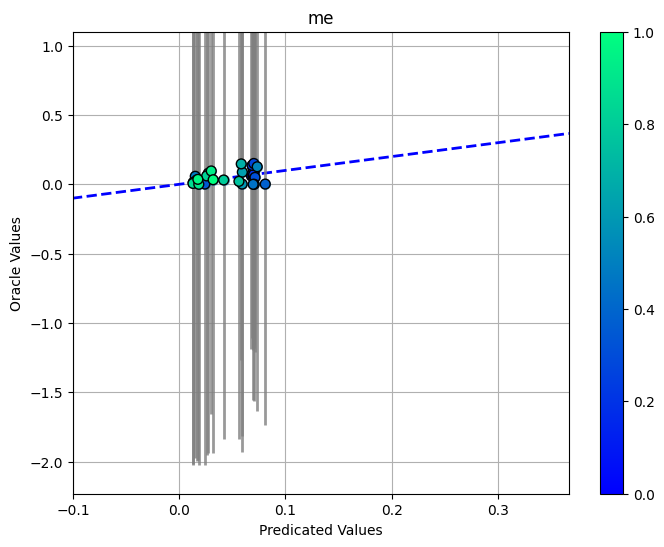

In [16]:
cv_plot(practice_mean,q1,q2,practice_y,title="me")

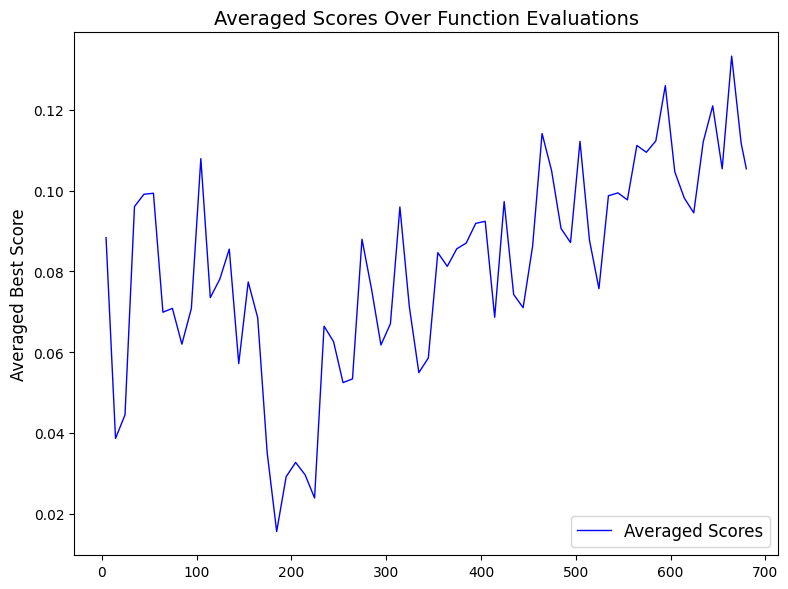

In [51]:

scores = practice_y[:800]  # Example scores
steps = np.arange(len(scores))  # Function evaluations (indices)


chunk_size = 10
averaged_scores = [np.mean(scores[i:i + chunk_size]) for i in range(0, len(scores), chunk_size)]

averaged_steps = [np.mean(steps[i:i + chunk_size]) for i in range(0, len(scores), chunk_size)]

# Plot the averaged line plot
plt.figure(figsize=(8, 6))
plt.plot(averaged_steps, averaged_scores, label="Averaged Scores", color='blue', linewidth=1)

# Customize the plot
plt.title("Averaged Scores Over Function Evaluations", fontsize=14)
plt.ylabel("Averaged Best Score", fontsize=12)
plt.grid(alpha=0.0)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

plt.show()

0.061224489795918366

In [54]:
import analysis

ModuleNotFoundError: No module named 'analysis'

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement matplotli (from versions: none)
ERROR: No matching distribution found for matplotli
Note: you may need to restart the kernel to use updated packages.


'run-me.npz'